In [237]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import cartopy.crs as ccrs

### Load Data and Station List

In [45]:
data_dir = './output/stations/sfba_local'    

# since all of the station data is in a uniform format, we can easily use xarray's open_mfdataset to combine it all automatically
data = xr.open_mfdataset(data_dir+"/axisem3d_synthetics.nc.*", engine="netcdf4", data_vars="different", concat_dim="dim_station", combine="nested")
data

<xarray.Dataset>
Dimensions:       (dim_time: 229, dim_station: 9477, dim_channel: 3)
Dimensions without coordinates: dim_time, dim_station, dim_channel
Data variables:
    data_time     (dim_time) float64 dask.array<where, shape=(229,), dtype=fl...
    data_wave     (dim_station, dim_channel, dim_time) float64 dask.array<con...
    list_channel  (dim_channel) object dask.array<where, shape=(3,), dtype=ob...
    list_station  (dim_station) object dask.array<concatenate, shape=(9477,),...

In [85]:
# load station location information in AxiSEM coordinates
stations = pd.read_csv("./input/STATIONS_OUTPUT.txt", delim_whitespace=True, header=2, names=["name","network","x","y","useless","depth"])

# find the permutation vector from the data output to the stations
stations["name_network"] = [net+f".{nam:04d}" for (nam, net) in zip(stations["name"], stations["network"])]
station_names_decoded = np.array([ls.decode("utf-8") for ls in data["list_station"].values])
permutation_vector = np.array([(nn==station_names_decoded).argmax() for nn in stations["name_network"]])
stations["permutation"] = permutation_vector
stations

,name,network,x,y,useless,depth,name_network,permutation
0,0,FAKE,0.0,-55000.0,0.0,0.0,FAKE.0000,516
1,1,FAKE,-10000.0,-54000.0,0.0,0.0,FAKE.0001,517
2,2,FAKE,-9000.0,-54000.0,0.0,0.0,FAKE.0002,332
3,3,FAKE,-8000.0,-54000.0,0.0,0.0,FAKE.0003,333
4,4,FAKE,-7000.0,-54000.0,0.0,0.0,FAKE.0004,334
...,...,...,...,...,...,...,...,...
9472,9472,FAKE,7000.0,54000.0,0.0,0.0,FAKE.9472,513
9473,9473,FAKE,8000.0,54000.0,0.0,0.0,FAKE.9473,514
9474,9474,FAKE,9000.0,54000.0,0.0,0.0,FAKE.9474,515
9475,9475,FAKE,10000.0,54000.0,0.0,0.0,FAKE.9475,558


In [86]:
# define coordinate transform for station locations
lat_pole = 37.7
lon_pole = -122.1
x_utm, y_utm = ccrs.UTM(zone=11).transform_point(lon_pole, lat_pole, src_crs=ccrs.Geodetic())

stations["x_utm"] = stations["x"] + x_utm
stations["y_utm"] = stations["y"] + y_utm
stations

,name,network,x,y,useless,depth,name_network,permutation,x_utm,y_utm
0,0,FAKE,0.0,-55000.0,0.0,0.0,FAKE.0000,516,50264.993837,4.129789e+06
1,1,FAKE,-10000.0,-54000.0,0.0,0.0,FAKE.0001,517,40264.993837,4.130789e+06
2,2,FAKE,-9000.0,-54000.0,0.0,0.0,FAKE.0002,332,41264.993837,4.130789e+06
3,3,FAKE,-8000.0,-54000.0,0.0,0.0,FAKE.0003,333,42264.993837,4.130789e+06
4,4,FAKE,-7000.0,-54000.0,0.0,0.0,FAKE.0004,334,43264.993837,4.130789e+06
...,...,...,...,...,...,...,...,...,...,...
9472,9472,FAKE,7000.0,54000.0,0.0,0.0,FAKE.9472,513,57264.993837,4.238789e+06
9473,9473,FAKE,8000.0,54000.0,0.0,0.0,FAKE.9473,514,58264.993837,4.238789e+06
9474,9474,FAKE,9000.0,54000.0,0.0,0.0,FAKE.9474,515,59264.993837,4.238789e+06
9475,9475,FAKE,10000.0,54000.0,0.0,0.0,FAKE.9475,558,60264.993837,4.238789e+06


### Process Data for Plotting

In [227]:
# put everything into simple numpy arrays for plotting, including sorting the wave data
x_coords = stations["x_utm"].values
y_coords = stations["y_utm"].values
t_coords = data["data_time"].values
displacement_data = data["data_wave"].values[stations["permutation"],:,:]/1e9 #convert from nm to m

# differentiate displacement data to get time data - for a real seismogram we would need to worry about the interaction between filter bandwidth & differentiation here
dt = t_coords[1]-t_coords[0] # should check that time sampling is even - in this case, it is
velocity_data = np.gradient(displacement_data, axis=2)/dt

# calculate PGV 
velocity_norm_data = np.sqrt(np.sum(np.square(velocity_data), axis=1))
pgv_data = np.maximum.accumulate(velocity_norm_data, axis=1) # calculate the "running" pgv

### Make Animation / Figure

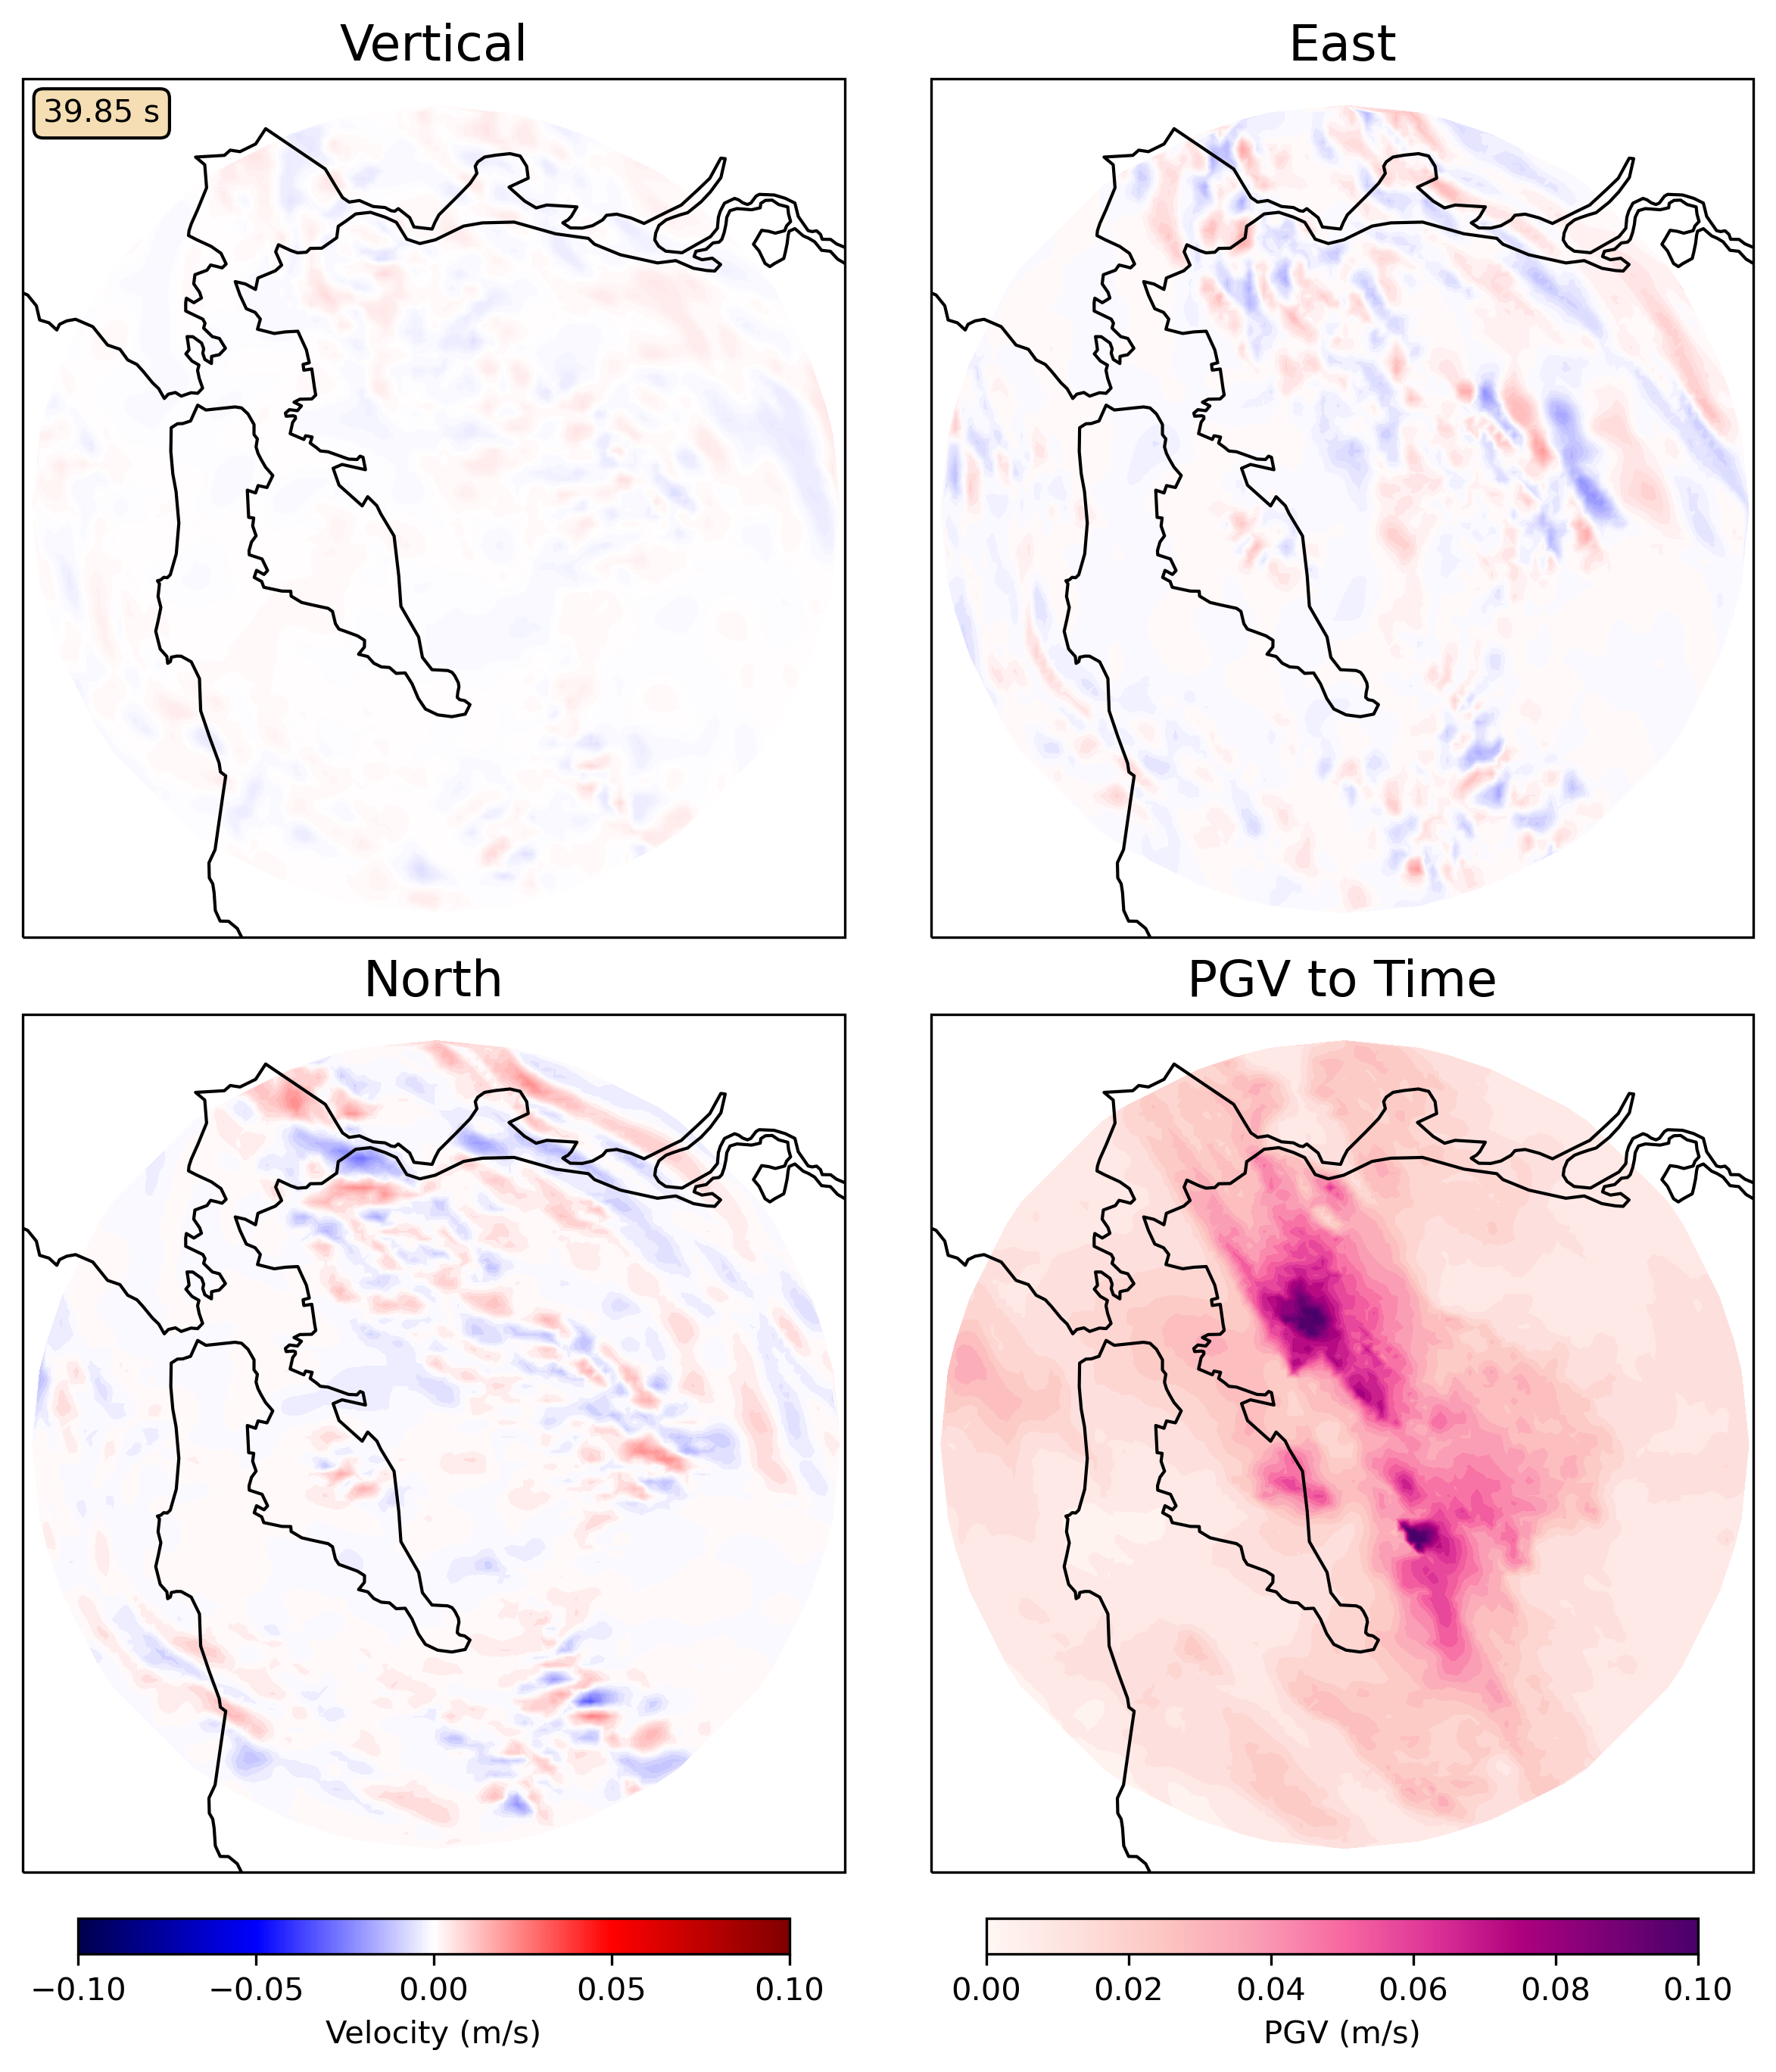

In [294]:
fig, axes = plt.subplots(2, 2, figsize=(8,9), dpi=300, constrained_layout = True, subplot_kw={'projection': ccrs.UTM(zone=11)})

i = 100
animate = True

axes[0,0].set_title("Vertical", fontsize=16)
axes[0,1].set_title("East", fontsize=16)
axes[1,0].set_title("North", fontsize=16)
axes[1,1].set_title("PGV to Time", fontsize=16)

for col in range(2):
    for row in range(2):
        axes[row,col].set_extent((-122.7,-121.5, 37.2, 38.2), crs=ccrs.Geodetic())
        axes[row,col].coastlines(resolution="10m")

# create fixed color bars using linear Normalize and dummy ScalarMapables
vel_norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
pgv_norm = mpl.colors.Normalize(vmin=0, vmax=0.1)
fig.colorbar(mpl.cm.ScalarMappable(norm=vel_norm, cmap='seismic'), ax=axes[1, 0], shrink=0.8, label="Velocity (m/s)", location="bottom")
fig.colorbar(mpl.cm.ScalarMappable(norm=pgv_norm, cmap='RdPu'), ax=axes[1, 1], shrink=0.8, label="PGV (m/s)", location="bottom")

if animate:
    # Use ArtistAnimation - flexible, but it is memory hungry as you have to make every plot element for every frame first
    frames = []
    props = dict(boxstyle='round', facecolor='wheat')
    for i in range(len(t_coords)):
        timelabel = axes[0,0].text(0.025,0.95, f"{t_coords[i]:.2f} s", transform=axes[0,0].transAxes, ha="left", bbox=props)
        # tricontourf lets us use an unstructured set of points for contouring, and doesn't look too bad when we have a lot of stations
        tcf00 = axes[0,0].tricontourf(x_coords, y_coords, velocity_data[:,2,i], levels=25, cmap="seismic", norm=vel_norm)
        tcf10 = axes[0,1].tricontourf(x_coords, y_coords, velocity_data[:,0,i], levels=25, cmap="seismic", norm=vel_norm)
        tcf01 = axes[1,0].tricontourf(x_coords, y_coords, velocity_data[:,1,i], levels=25, cmap="seismic", norm=vel_norm)
        tcf11 = axes[1,1].tricontourf(x_coords, y_coords, pgv_data[:,i], levels=25, cmap="RdPu", norm=pgv_norm)
        # collect each frame and append to frame list
        frames.append(tcf00.collections+tcf10.collections+tcf01.collections+tcf11.collections+[timelabel]) 
    
    anim = animation.ArtistAnimation(fig, frames)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

    anim.save('finite_fault_movie.mp4', writer=writer)
    
else:    
    fig.suptitle(f"Time = {t_coords[i]:.2f} s", fontsize=16)
    axes[0,0].tricontourf(x_coords, y_coords, velocity_data[:,2,i], levels=100, cmap="seismic", norm=vel_norm),
    axes[0,1].tricontourf(x_coords, y_coords, velocity_data[:,0,i], levels=100, cmap="seismic", norm=vel_norm),
    axes[1,0].tricontourf(x_coords, y_coords, velocity_data[:,1,i], levels=100, cmap="seismic", norm=vel_norm),
    axes[1,1].tricontourf(x_coords, y_coords, pgv_data[:,i], levels=100, cmap="RdPu", norm=pgv_norm)
    fig.savefig("finite_fault_figure.pdf")